In [1]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS 495 DataScience Capstone Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS 495 DataScience Capstone Project


In [2]:
# --- Imports ---
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# --- Configuration ---
full_data = True
vocab_limit = 40000
enc_max_len = 64
dec_max_len = 150
max_dec_input_length = dec_max_len - 1
embedding_dim = 128
units = 128
batch = 64
repeat = 20
patience = 20
custom_learning_rate = 5e-5
adam_optimizer = Adam(learning_rate=custom_learning_rate)
val_ratio = 0.2
min_delta = 0.01

In [4]:
# --- Load Dataset ---
train_df = pd.read_csv("prompt_synopsis_train.csv")
if not full_data:
    train_df = train_df.sample(n=1000, random_state=42).reset_index(drop=True)

In [5]:
# --- Clean Text ---
def clean_text(text):
    return text.lower().strip().replace('\n', ' ')

for col in ['prompt', 'synopsis']:
    train_df[col] = train_df[col].astype(str).apply(clean_text)

In [6]:
# --- Tokenizer ---
PAD_ID = 0
OOV_ID = 1
BOS_ID = 2
EOS_ID = 3
NUM_SPECIAL_TOKENS_RESERVED = 4
num_words_to_fit = vocab_limit - NUM_SPECIAL_TOKENS_RESERVED

tokenizer = Tokenizer(num_words=num_words_to_fit, oov_token='<OOV>', filters='')
tokenizer.fit_on_texts(train_df['prompt'].tolist() + train_df['synopsis'].tolist())

new_word_index = {
    "<PAD>": PAD_ID,
    "<OOV>": OOV_ID,
    "<BOS>": BOS_ID,
    "<EOS>": EOS_ID
}
new_index_word = {v: k for k, v in new_word_index.items()}
next_available_id = NUM_SPECIAL_TOKENS_RESERVED
content_words_assigned = 0

for word, original_id in sorted(tokenizer.word_index.items(), key=lambda item: item[1]):
    if word in new_word_index:
        continue
    if content_words_assigned < num_words_to_fit:
        new_word_index[word] = next_available_id
        new_index_word[next_available_id] = word
        next_available_id += 1
        content_words_assigned += 1
    else:
        break

tokenizer.word_index = new_word_index
tokenizer.index_word = new_index_word
vocab_size = vocab_limit

with open("tokenizer_LSTM-GRU_40k.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [7]:
# --- Sequence Tokenization ---
input_seqs = tokenizer.texts_to_sequences(train_df['prompt'])
output_seqs = tokenizer.texts_to_sequences(train_df['synopsis'])

target_augmented = [[BOS_ID] + seq + [EOS_ID] for seq in output_seqs]
decoder_input_ids = [seq[:-1] for seq in target_augmented]
decoder_target_ids = [seq[1:] for seq in target_augmented]

encoder_input_data = pad_sequences(input_seqs, maxlen=enc_max_len, padding='post', truncating='post', value=PAD_ID)
decoder_input_data = pad_sequences(decoder_input_ids, maxlen=max_dec_input_length, padding='post', truncating='post', value=PAD_ID)
decoder_target_data = pad_sequences(decoder_target_ids, maxlen=max_dec_input_length, padding='post', truncating='post', value=PAD_ID)
decoder_target_data = np.expand_dims(decoder_target_data, axis=-1)

In [8]:
# --- Train/Validation Split ---
X_train_enc, X_val_enc, X_train_dec, X_val_dec, y_train, y_val = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=val_ratio, random_state=42
)

train_inputs = (X_train_enc, X_train_dec)
val_inputs = [X_val_enc, X_val_dec]

In [9]:
# --- LSTM Encoder + GRU Decoder Model ---
encoder_inputs = Input(shape=(enc_max_len,), name='encoder_input_lstm')
encoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
_, enc_h, enc_c = LSTM(units, return_state=True, unroll=True, name='encoder_lstm')(encoder_embedding)
encoder_state = enc_h  # only use hidden state for GRU

decoder_inputs = Input(shape=(max_dec_input_length,), name='decoder_input_gru')
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_gru, _ = GRU(units, return_sequences=True, return_state=True, unroll=True, name='decoder_gru')(decoder_embedding, initial_state=encoder_state)
decoder_dense = Dense(vocab_size, activation='softmax')(decoder_gru)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_dense)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
# --- Summary ---
print("LSTM-GRU Model Summary (40k Vocab)")
model.summary()

LSTM-GRU Model Summary (40k Vocab)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_lstm  │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input_gru   │ (None, 149)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64, 128)   │  5,120,000 │ encoder_input_ls… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 64)        │          0 │ encoder_input_ls… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 149, 128)  │  5,120,000 │ decoder_input_gr… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 128),     │    131,584 │ embedding[0][0],  │
│                     │ (None, 128),      │            │ not_equal[0][0]   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_gru (GRU)   │ [(None, 149,      │     99,072 │ embedding_1[0][0… │
│                     │ 128), (None,      │            │ encoder_lstm[0][… │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 149,       │  5,160,000 │ decoder_gru[0][0] │
│                     │ 40000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,630,656 (59.63 MB)

 Trainable params: 15,630,656 (59.63 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# --- Callbacks ---
model_path = "lstm_gru_model_40k.keras"
checkpoint_cb = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=patience, min_delta=min_delta, restore_best_weights=True, verbose=1)

In [12]:
# --- Training ---
history = model.fit(
    train_inputs,
    y_train,
    batch_size=batch,
    epochs=repeat,
    validation_data=(val_inputs, y_val),
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.0313 - loss: 9.4594
Epoch 1: val_loss improved from inf to 7.38153, saving model to lstm_gru_model_40k.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 249s 179ms/step - accuracy: 0.0314 - loss: 9.4580 - val_accuracy: 0.0372 - val_loss: 7.3815
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0373 - loss: 7.3612
Epoch 2: val_loss improved from 7.38153 to 7.35399, saving model to lstm_gru_model_40k.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0373 - loss: 7.3612 - val_accuracy: 0.0372 - val_loss: 7.3540
Epoch 3/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0374 - loss: 7.3511
Epoch 3: val_loss improved from 7.35399 to 7.35268, saving model to lstm_gru_model_40k.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0374 - loss: 7.3511 - val_accuracy: 0.0372 - val_loss: 7.3527
Epoch 4/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0375 - loss: 7.3490
Epoch 4: val_loss

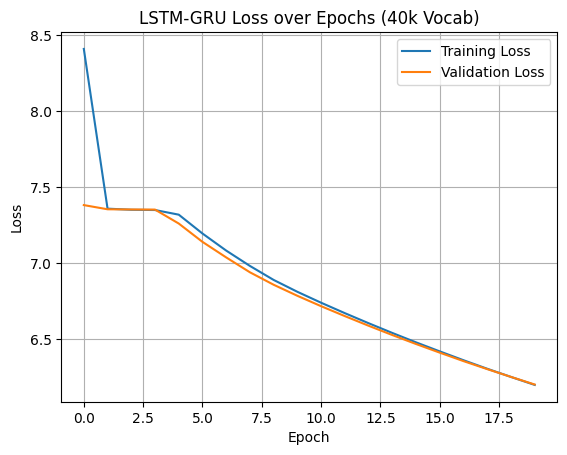

In [13]:
# --- Plot Loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM-GRU Loss over Epochs (40k Vocab)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# --- Evaluation ---
model.load_weights(model_path)
val_loss, val_acc = model.evaluate(val_inputs, y_val, verbose=0)
perplexity = np.exp(val_loss)
print(f"LSTM-GRU Model Perplexity (40k Vocab): {perplexity:.2f}")

LSTM-GRU Model Perplexity (40k Vocab): 492.03
